See code at https://github.com/google-research/vision_transformer/

See paper at https://arxiv.org/abs/2010.11929

This Colab allows you to run the [JAX](https://jax.readthedocs.org) implementation of the Vision Transformer.

##### Copyright 2020 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/vision_transformer/blob/master/vit_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

Needs to be executed once in every VM.

The cell below downloads the code from Github and install necessary dependencies.

In [ ]:
#@markdown Select whether you would like to store data in your personal drive.
#@markdown
#@markdown If you select **yes**, you will need to authorize Colab to access
#@markdown your personal drive
#@markdown
#@markdown If you select **no**, then any changes you make will diappear when
#@markdown this Colab's VM restarts after some time of inactivity...
use_gdrive = 'no'  #@param ["yes", "no"]

if use_gdrive == 'yes':
  from google.colab import drive
  drive.mount('/gdrive')
  root = '/gdrive/My Drive/vision_transformer_colab'
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')
else:
  from IPython import display
  display.display(display.HTML(
      '<h1 style="color:red">CHANGES NOT PERSISTED</h1>'))

In [ ]:
# Clone repository and pull latest changes 지민이가 씀
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull

Cloning into 'vision_transformer'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 25 (delta 1), reused 12 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), done.
Already up to date.


In [ ]:
!pip install -qr vision_transformer/vit_jax/requirements.txt

     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 153kB 6.7MB/s 
     |████████████████████████████████| 92kB 4.0MB/s 
     |████████████████████████████████| 20.1MB 64.7MB/s 
     |████████████████████████████████| 137.3MB 81kB/s 
     |████████████████████████████████| 4.3MB 40.1MB/s 
     |████████████████████████████████| 460kB 49.6MB/s 
ERROR: tensorflow 2.4.0 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement tensorflow-estimator<2.5.0,>=2.4.0rc0, but you'll have tensorflow-estimator 2.3.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


### Imports

In [ ]:
# 미리 학습된 모델들 모두 보기
!gsutil ls -lh gs://vit_models/*

      65 B  2020-10-21T07:59:00Z  gs://vit_models/README.txt

gs://vit_models/imagenet21k+imagenet2012/:
377.57 MiB  2020-11-30T16:17:02Z  gs://vit_models/imagenet21k+imagenet2012/R50+ViT-B_16.npz
330.29 MiB  2020-10-29T17:05:52Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
 331.4 MiB  2020-10-20T11:48:22Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz
336.89 MiB  2020-10-20T11:47:36Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz
  1.13 GiB  2020-10-29T17:08:31Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16-224.npz
  1.14 GiB  2020-10-20T11:53:44Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16.npz
  1.14 GiB  2020-10-20T11:50:56Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_32.npz

gs://vit_models/imagenet21k/:
439.85 MiB  2020-11-30T10:10:15Z  gs://vit_models/imagenet21k/R50+ViT-B_16.npz
393.69 MiB  2020-10-22T21:38:39Z  gs://vit_models/imagenet21k/ViT-B_16.npz
400.01 MiB  2020-11-02T08:30:56Z  gs://vit_models/imagenet21k/ViT-B_32.npz
  2.46 

In [ ]:
# 미리 학습된 모델 다운로드
model = 'ViT-B_16'
![ -e "$model".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model".npz .

Copying gs://vit_models/imagenet21k/ViT-B_16.npz...
| [1 files][393.7 MiB/393.7 MiB]                                                
Operation completed over 1 objects/393.7 MiB.                                    


In [ ]:
#@markdown TPU setup : Boilerplate for connecting JAX to TPU.

import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  # Make sure the Colab Runtime is set to Accelerator: TPU.
  import requests
  if 'TPU_DRIVER_MODE' not in globals():
    url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver0.1-dev20191206'
    resp = requests.post(url)
    TPU_DRIVER_MODE = 1

  # The following is required to use TPU Driver as JAX's backend.
  from jax.config import config
  config.FLAGS.jax_xla_backend = "tpu_driver"
  config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
  print('Registered TPU:', config.FLAGS.jax_backend_target)
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

Registered TPU: grpc://10.122.133.146:8470


In [ ]:
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import tqdm

# cpu/gpu/tpu의 개수 보기
jax.local_devices()

[TpuDevice(id=0, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=2, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=3, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=4, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=5, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=6, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=7, host_id=0, coords=(0,0,0), core_on_chip=0)]

In [ ]:
# 오른쪽에 코드 파일들 열기
from google.colab import files
files.view('vision_transformer/vit_jax/checkpoint.py')
files.view('vision_transformer/vit_jax/input_pipeline.py')
files.view('vision_transformer/vit_jax/models.py')
files.view('vision_transformer/vit_jax/momentum_clip.py')
files.view('vision_transformer/vit_jax/train.py')
files.view('vision_transformer/vit_jax/hyper.py')

FileNotFoundError: ignored

In [ ]:
# 위 파일들 import하기
# 파일들을 오른쪽 에디터에서 변경하고 다시 import하면 바로 반영된다.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import hyper
from vit_jax import input_pipeline
from vit_jax import logging
from vit_jax import models
from vit_jax import momentum_clip
from vit_jax import train

logger = logging.setup_logger('./logs')

In [ ]:
# 이미지 관련 함수들

labelnames = dict(
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')
)

# 이미지 label 반환
def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))# 하나의 이미지 안에 여러 그래프(그리드) 그리기
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

### Load dataset

In [ ]:
dataset = 'cifar10'
batch_size = 512  # GPU 하나로 돌리면 256으로 변경하기

In [ ]:
# input_pipeline 파일의 DATASET_PRESETS 딕셔너리에 데이터셋들이 정의되어 있는지 확인하기
# 오른쪽 에디터에서 확인
num_classes = input_pipeline.get_dataset_info(dataset, 'train')['num_classes']
# training을 위한 데이터셋, repeat 무한
ds_train = input_pipeline.get_data(
    dataset=dataset, mode='train', repeats=None, batch_size=batch_size,
)
# 검증을 위한 데이터셋, repeat 한번
ds_test = input_pipeline.get_data(
    dataset=dataset, mode='test', repeats=1, batch_size=batch_size,
)

2020-12-17 18:46:00,900 [INFO] absl: Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
2020-12-17 18:46:01,245 [INFO] absl: Load dataset info from /tmp/tmpif5jlkv8tfds
2020-12-17 18:46:01,257 [INFO] absl: Field info.citation from disk and from code do not match. Keeping the one from code.
2020-12-17 18:46:01,268 [INFO] absl: Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
2020-12-17 18:46:01,564 [INFO] absl: Load dataset info from /tmp/tmp4ow2gvuftfds
2020-12-17 18:46:01,571 [INFO] absl: Field info.citation from disk and from code do not match. Keeping the one from code.
2020-12-17 18:46:01,574 [INFO] absl: Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
2020-12-17 18:46:01,881 [INFO] absl: Load dataset info from /tmp/tmpguof900mtfds
2020-12-17 18:46:01,890 [INFO] absl: Field info.citation from disk and from code do not match. Keeping the one from code.
2020-12-17 18:46:01,897 [

2020-12-17 18:46:02,638 [INFO] absl: Downloading https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz into /root/tensorflow_datasets/downloads/cs.toronto.edu_kriz_cifar-10-binaryODHPtIjLh3oLcXirEISTO7dkzyKjRCuol6lV8Wc6C7s.tar.gz.tmp.38377f3d21f049cb92965a21ce098808...
2020-12-17 18:46:10,804 [INFO] absl: Generating split train


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteR2BTDP/cifar10-train.tfrecord


2020-12-17 18:47:12,573 [INFO] absl: Done writing /root/tensorflow_datasets/cifar10/3.0.2.incompleteR2BTDP/cifar10-train.tfrecord. Shard lengths: [50000]
2020-12-17 18:47:12,578 [INFO] absl: Generating split test


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteR2BTDP/cifar10-test.tfrecord


2020-12-17 18:47:25,104 [INFO] absl: Done writing /root/tensorflow_datasets/cifar10/3.0.2.incompleteR2BTDP/cifar10-test.tfrecord. Shard lengths: [10000]
2020-12-17 18:47:25,108 [INFO] absl: Skipping computing stats for mode ComputeStatsMode.SKIP.
2020-12-17 18:47:25,118 [INFO] absl: Constructing tf.data.Dataset for split train[:98%], from /root/tensorflow_datasets/cifar10/3.0.2


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.


2020-12-17 18:47:25,745 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/dispatch.py:201: sample_distorted_bounding_box (from tensorflow.python.ops.image_ops_impl) is deprecated and will be removed in a future version.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
2020-12-17 18:47:25,917 [INFO] absl: Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
2020-12-17 18:47:25,926 [INFO] absl: Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
2020-12-17 18:47:25,933 [INFO] absl: Reusing dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)
2020-12-17 18:47:25,938 [INFO] absl: Constructing tf.data.Dataset for split test, from /root/tensorflow_datasets/cifar10/3.0.2


In [ ]:
# 설명을 위한 테스트 이미지 배치 가져오기
batch = next(iter(ds_test.as_numpy_iterator()))
# 데이터 shape 확인 : [로컬 디바이스 개수, 로컬 배치 사이즈, 높이, 너비, 클래스?]
batch['image'].shape

(8, 64, 384, 384, 3)

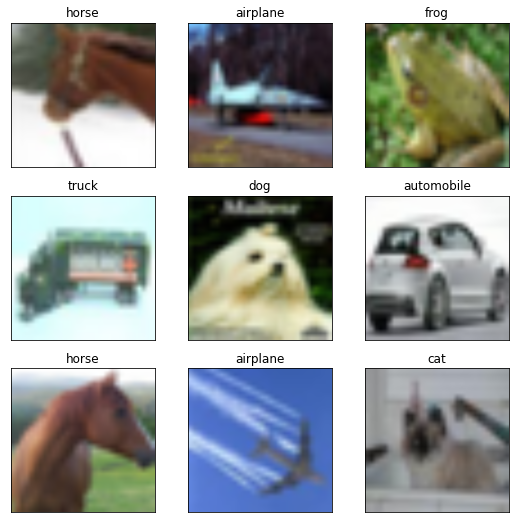

In [ ]:
# label이 붙은 이미지들 보기
images, labels = batch['image'][0][:9], batch['label'][0][:9] #9개 이미지 
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)# 그리드 그려진 이미지 보기

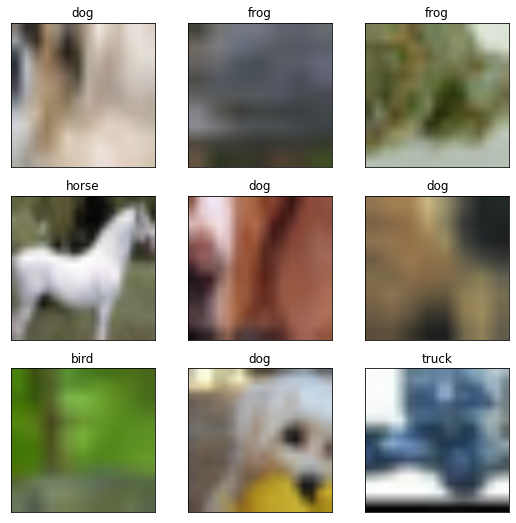

In [ ]:
# label이 붙은 train 이미지들 보기
# train과 test dataset은 다르게 전처리 된다.
# 오른쪽의 input_pipeline.get_data() 참고하기
batch = next(iter(ds_train.as_numpy_iterator()))
images, labels = batch['image'][0][:9], batch['label'][0][:9]# 9개 이미지
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles) # 그리드 그려진 이미지 보기

### Load pre-trained

In [ ]:
# Load model definition & initialize random parameters.
# 모델 정의서를 가져오고, random parameter들을 초기화하기
VisionTransformer = models.KNOWN_MODELS[model].partial(num_classes=num_classes)
_, params = VisionTransformer.init_by_shape(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    [(batch['image'].shape[1:], batch['image'].dtype.name)])

In [ ]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
# 미리 학습된 체크포인트를 가져와서 변환한다.
# 실제 미리 학습된 모델 결과를 가져오는 것을 포함하지만, 파라미터를 조금씩 수정한다.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model}.npz',
    init_params=params,
    model_config=models.CONFIGS[model],
    logger=logger,
)

2020-12-17 18:48:56,742 [WARNING] vit_jax.logging: Inspect recovered empty keys:
{'pre_logits'}
2020-12-17 18:48:56,746 [INFO] vit_jax.logging: Inspect extra keys:
{'pre_logits/kernel', 'pre_logits/bias'}
2020-12-17 18:48:56,760 [INFO] vit_jax.logging: load_pretrained: drop-head variant
2020-12-17 18:48:56,775 [INFO] vit_jax.logging: load_pretrained: resized variant: (1, 197, 768) to (1, 577, 768)
2020-12-17 18:48:56,781 [INFO] vit_jax.logging: load_pretrained: grid-size from 14 to 24


### Evaluate

In [ ]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params) # 장치로 param들 복제, jax == numpy api
print('params.cls:', type(params['cls']).__name__, params['cls'].shape) # cls의 shape== (1, 1, 768)
print('params_repl.cls:', type(params_repl['cls']).__name__, params_repl['cls'].shape) # 복제본 ShardedDeviceArray (8, 1, 1, 768)

params.cls: ndarray (1, 1, 768)
params_repl.cls: ShardedDeviceArray (8, 1, 1, 768)


In [ ]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(VisionTransformer.call) # 여러 tpu 코어에서 병렬 실행

In [ ]:
#정확도 구하기
def get_accuracy(params_repl):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  steps = input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size # dataset의 test의 'num_examples'의 value 값을 배치 사이즈로 나눈 것 만큼 반복
  for _, batch in zip(tqdm.notebook.trange(steps), ds_test.as_numpy_iterator()): #진행표시바
    predicted = vit_apply_repl(params_repl, batch['image']) #param_repl과 batch의 image 해당 value값 넣어 예측한 값
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1) # 정답과 일치하는지 확인 (8, 64)에서 64
    good += is_same.sum() # 같은 것 누적
    total += len(is_same.flatten()) # 512
  return good / total

In [ ]:
# Random performance without fine-tuning.
get_accuracy(params_repl)

2020-12-17 19:43:25,161 [INFO] absl: Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2


DeviceArray(0.10063734, dtype=float32)

### Fine-tune

In [ ]:
# 100 Steps take approximately 15 minutes in the TPU runtime.
total_steps = 100
warmup_steps = 5
decay_type = 'cosine' #weight decay
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 8
base_lr = 0.03

In [ ]:
# Check out train.make_update_fn in the editor on the right side for details.
update_fn_repl = train.make_update_fn(VisionTransformer.call, accum_steps)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
opt = momentum_clip.Optimizer(grad_norm_clip=grad_norm_clip).create(params) # momentum optimizer 사용
opt_repl = flax.jax_utils.replicate(opt)

In [ ]:
lr_fn = hyper.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
# Prefetch entire learning rate schedule onto devices. Otherwise we would have
# a slow transfer from host to devices in every step.
lr_iter = hyper.lr_prefetch_iter(lr_fn, 0, total_steps)
# Initialize PRNGs for dropout.
update_rngs = jax.random.split(jax.random.PRNGKey(0), jax.local_device_count()) #PRNGKey(0) : DeviceArray([0, 0], dtype=uint32)

In [ ]:
# The world's simplest training loop.
# Completes in ~20 min on the TPU runtime.
for step, batch, lr_repl in zip(
    tqdm.notebook.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
    lr_iter
):

  opt_repl, loss_repl, update_rngs = update_fn_repl(
      opt_repl, lr_repl, batch, update_rngs) # make_update_fn한 것

In [ ]:
# Should be ~97.2% for CIFAR10
# Should be ~71.2% for CIFAR100
get_accuracy(opt_repl.target)

2020-12-17 19:46:33,016 [INFO] absl: Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2


### Inference

In [ ]:
# Download model pre-trained on imagenet21k and fine-tuned on imagenet2012.
![ -e "$model"_imagenet2012.npz ] || gsutil cp gs://vit_models/imagenet21k+imagenet2012/"$model".npz "$model"_imagenet2012.npz

In [ ]:
VisionTransformer = models.KNOWN_MODELS[model].partial(num_classes=1000)
# Load and convert pretrained checkpoint.
params = checkpoint.load(f'{model}_imagenet2012.npz')
params['pre_logits'] = {}  # Need to restore empty leaf for Flax.

In [ ]:
# Get imagenet labels.
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

--2020-10-22 18:15:43--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt.1’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0.004s  

2020-10-22 18:15:43 (5.48 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt.1’ saved [21675/21675]



--2020-10-22 18:26:58--  https://picsum.photos/384
Resolving picsum.photos (picsum.photos)... 104.26.5.30, 104.26.4.30, 172.67.74.163, ...
Connecting to picsum.photos (picsum.photos)|104.26.5.30|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://i.picsum.photos/id/757/384/384.jpg?hmac=zpRYJHidvRCCAt-3LtpEepmDG2vCfTuOfVmlt0T-pJQ [following]
--2020-10-22 18:26:58--  https://i.picsum.photos/id/757/384/384.jpg?hmac=zpRYJHidvRCCAt-3LtpEepmDG2vCfTuOfVmlt0T-pJQ
Resolving i.picsum.photos (i.picsum.photos)... 104.26.5.30, 172.67.74.163, 104.26.4.30, ...
Connecting to i.picsum.photos (i.picsum.photos)|104.26.5.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘picsum.jpg’

picsum.jpg              [ <=>                ]  23.53K  --.-KB/s    in 0.1s    

2020-10-22 18:27:00 (186 KB/s) - ‘picsum.jpg’ saved [24095]



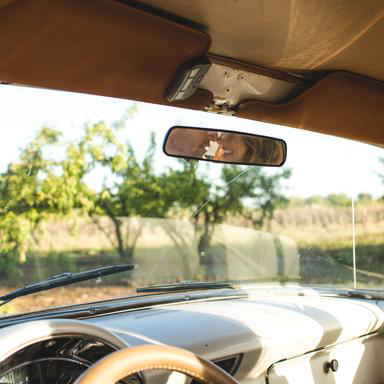

In [ ]:
# Get a random picture with the correct dimensions.
!wget https://picsum.photos/384 -O picsum.jpg
import PIL
img = PIL.Image.open('picsum.jpg')
img

In [ ]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = VisionTransformer.call(params, (np.array(img) / 128 - 1)[None, ...])

In [ ]:
preds = flax.nn.softmax(logits)
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')

0.76433 : convertible
0.01839 : beach_wagon, station_wagon, wagon, estate_car, beach_waggon, station_waggon, waggon
0.01566 : car_mirror
0.01226 : cab, hack, taxi, taxicab
0.01132 : limousine, limo
0.01067 : golfcart, golf_cart
0.01041 : recreational_vehicle, RV, R.V.
0.01026 : Model_T
0.00805 : minibus
0.00767 : odometer, hodometer, mileometer, milometer
